In [3]:
import os
import shutil
import random

In [4]:
# 将原始数据拆分成训练和测试
data_root = 'pics/' # 数据路径

# 拆分结果路径
train_root = 'train/'
test_root = 'test/'

# 创建结果路径
if os.path.exists(train_root):
    shutil.rmtree(train_root)
os.mkdir(train_root)
if os.path.exists(test_root):
    shutil.rmtree(test_root)
os.mkdir(test_root)
    
# 获取类别名字
classes_name = os.listdir(data_root)
print(classes_name)


['negative', 'neutral', 'positive']


In [5]:
for class_id in classes_name:
    # 创建每个类别路径
    os.mkdir(train_root+class_id)
    os.mkdir(test_root+class_id)
    
    # 获取所有图片名字
    image_list = os.listdir(data_root + class_id)
    random.shuffle(image_list) # 随机打乱
    split_rate = 0.1 # 训练和测试切分比例
    train_size = int(len(image_list) * (1 - split_rate))
    test_size = len(image_list) - train_size
    print('train_size: %d   test_size: %d' % (train_size, test_size))

    # 复制数据集到train和test
    image_list_train = image_list[:train_size]
    image_list_test = image_list[-test_size:]

    for img in image_list_train:
        shutil.copy(data_root + class_id + '/' + img, train_root + class_id + '/' + img)
    for img in image_list_test:
        shutil.copy(data_root + class_id + '/' + img, test_root + class_id + '/' + img)

train_size: 67   test_size: 8
train_size: 224   test_size: 25
train_size: 316   test_size: 36


In [21]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model

import os
import numpy as np
import matplotlib.pyplot as plt
keras = tf.keras

In [22]:
# 训练和测试数据路径
train_dir = 'train'
validation_dir = 'test'

print('train data dir', train_dir)
print('valid data dir', validation_dir)


train data dir train
valid data dir test


In [23]:

batch_size = 4 # 

epochs = 30 # 训练轮数

# 图像输入尺寸设置
IMG_HEIGHT = 224
IMG_WIDTH = 224

# 类别数目
num_classes = 3

# 训练数据有
train_image_generator = ImageDataGenerator(rescale=1. / 255,
                                           rotation_range = 10, #角度值，0-180.表示图像随机旋转的角度范围
                                           width_shift_range = 0.2, #平移比例，下同
                                           height_shift_range = 0.2,
                                           shear_range = 0.2, #随机错切变换角度
                                           zoom_range = 0.2, #随即缩放比例
                                           horizontal_flip = True, #随机将一半图像水平翻转
                                           fill_mode='nearest') #填充新创建像素的方法

# 验证数据
validation_image_generator = ImageDataGenerator(rescale=1. / 255,
                                                rotation_range = 10, #角度值，0-180.表示图像随机旋转的角度范围
                                                width_shift_range = 0.2, #平移比例，下同
                                                height_shift_range = 0.2,
                                                shear_range = 0.2, #随机错切变换角度
                                                zoom_range = 0.2, #随即缩放比例
                                                horizontal_flip = True, #随机将一半图像水平翻转
                                                fill_mode='nearest') #填充新创建像素的方法 

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                          class_mode='categorical')
# 训练和验证数据的数量
total_train_images = train_data_gen.n
total_valid_images = val_data_gen.n

Found 607 images belonging to 3 classes.
Found 69 images belonging to 3 classes.


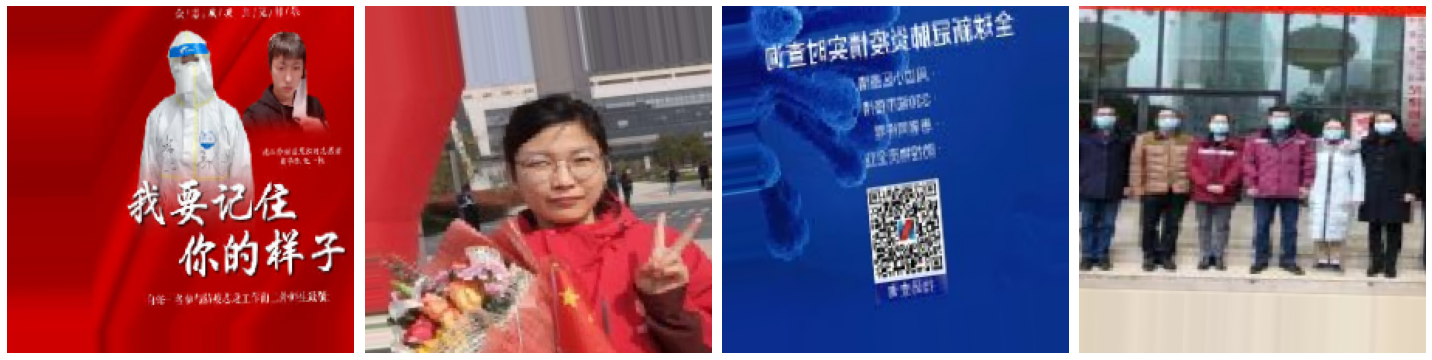

In [24]:
# 数据可视化
# 获取一个batch的数据
sample_training_images, _ = next(train_data_gen)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 4, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


plotImages(sample_training_images[:4])

In [25]:
# 建立模型
# 设置输入图像尺寸
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

# 建立MobileNetV2模型，利用ImageNet上训练的MobileNet提取特征
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# 模型参数可学习
base_model.trainable = True

# 打印模型结构
base_model.summary()
plot_model
# 提取特征的尺寸
sample_training_images.shape
#feature_batch = base_model(sample_training_images)
#print(feature_batch.shape)
#plot_model(base_model, to_file='model.png'，show_shapes=true)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 114, 114, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
__________

(4, 224, 224, 3)

In [26]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # 平均池化层
prediction_layer = keras.layers.Dense(num_classes, activation='softmax') # 全连接层

In [28]:
# 编译模型：模型结构为ImageNet上的特征提取部分+平均池化+全连接层
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])


# 学习率设置
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 打印模型结构
model.summary()
plot_model                                          

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 3,231,939
Trainable params: 3,210,051
Non-trainable params: 21,888
_________________________________________________________________


<function keras.utils.vis_utils.plot_model>

In [1]:
jupyter nbconvert --to script  classification.ipynb

SyntaxError: invalid syntax (<ipython-input-1-6ae816fffbdd>, line 1)